# SMYLE & DPLE Global NPP Skill

In [28]:
%load_ext autoreload
%autoreload 2
import xarray as xr 
import numpy as np  
import cftime
import copy
import scipy.stats
from scipy import signal
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
%matplotlib inline

from SMYLEutils import calendar_utils as cal
from SMYLEutils import stat_utils as stat
from SMYLEutils import mapplot_utils as maps
from SMYLEutils import colorbar_utils as cbars
from SMYLEutils import io_utils as io

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data I/O using Dask

### Create Dask Cluster

In [2]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=1,
        memory='25GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=25GB',
        project='NCGD0011',
        walltime='02:00:00',
        interface='ib0',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })
    client = Client(cluster)
    return cluster, client

In [3]:
cluster, client = get_ClusterClient()
cluster.scale(20) 

In [4]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kristenk/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kristenk/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.35:39810,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kristenk/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


### Read in POP monthly data; Convert to Seasonal averages (DJF, MAM, JJA, SON)
- Chosen field is returned as a dask array with leading dimensions of Y (initialization year), M (ensemble member), and L (lead season). For example, for November starts, L=1 corresponds to first DJF season.
- "time" which gives prediction verification time (centered time for a given season) is also dimensioned with (Y,L)

In [5]:
# This preprocessor will return a seasonal mean field
def preprocessor(ds0,nlead,field):
    """ This preprocessor is applied on an individual timeseries file basis. Edit this appropriately
    for a your analysis to speed up processing. 
    """
    ds0 = cal.time_set_mid(ds0,'time')
    d0 = ds0[field].isel(time=slice(1, nlead))
    d0 = d0.assign_coords({"lon":ds0.TLONG, "lat":ds0.TLAT})
    d0 = cal.mon_to_seas(d0)
    d0 = d0.assign_coords(L=("time", np.arange(d0.sizes["time"])+1))
    d0 = d0.swap_dims({"time": "L"})
    d0 = d0.to_dataset(name=field)
    d0 = d0.reset_coords(["time"])
    d0["time"] = d0.time.expand_dims("Y")
    return d0

In [6]:
%%time
# SMYLE-NOV NPP data
# process all 20 ensemble members, all start dates from 1970-2018:
field = 'photoC_TOT_zint_100m'
datadir = '/glade/campaign/cesm/development/espwg/SMYLE/archive/'
casename = 'b.e21.BSMYLE.f09_g17.????-MM.EEE'
filetype = '.pop.h.'
filetemplate = datadir+casename+'/ocn/proc/tseries/month_1/'+casename+filetype+field+'.*.nc'
ens = 20 
nlead = 24
firstyear = 1970
lastyear  = 2018
startmonth = 11
smyle11 = io.get_monthly_data(filetemplate,filetype,ens,nlead,field,firstyear,lastyear,startmonth,preprocessor)
smyle11.nbytes/1e9 #GB

CPU times: user 27.9 s, sys: 12.3 s, total: 40.2 s
Wall time: 1min 11s


7.712935592

In [7]:
%%time
smyle11=smyle11.load()

CPU times: user 53.2 s, sys: 11.6 s, total: 1min 4s
Wall time: 1min 9s


In [8]:
%%time
# SMYLE-FEB NPP data
# process all 20 ensemble members, all start dates from 1970-2018:
field = 'photoC_TOT_zint_100m'
datadir = '/glade/campaign/cesm/development/espwg/SMYLE/archive/'
casename = 'b.e21.BSMYLE.f09_g17.????-MM.EEE'
filetype = '.pop.h.'
filetemplate = datadir+casename+'/ocn/proc/tseries/month_1/'+casename+filetype+field+'.*.nc'
ens = 20 
nlead = 24
firstyear = 1970
lastyear  = 2018
startmonth = 2
smyle02 = io.get_monthly_data(filetemplate,filetype,ens,nlead,field,firstyear,lastyear,startmonth,preprocessor)
smyle02.nbytes/1e9 #GB

CPU times: user 30.2 s, sys: 12.4 s, total: 42.7 s
Wall time: 2min 26s


7.712935592

In [9]:
%%time
smyle02=smyle02.load()

CPU times: user 56.5 s, sys: 11.2 s, total: 1min 7s
Wall time: 1min 31s


In [10]:
%%time
# SMYLE-MAY NPP data
# process all 20 ensemble members, all start dates from 1970-2018:
field = 'photoC_TOT_zint_100m'
datadir = '/glade/campaign/cesm/development/espwg/SMYLE/archive/'
casename = 'b.e21.BSMYLE.f09_g17.????-MM.EEE'
filetype = '.pop.h.'
filetemplate = datadir+casename+'/ocn/proc/tseries/month_1/'+casename+filetype+field+'.*.nc'
ens = 20 
nlead = 24
firstyear = 1970
lastyear  = 2018
startmonth = 5
smyle05 = io.get_monthly_data(filetemplate,filetype,ens,nlead,field,firstyear,lastyear,startmonth,preprocessor)
smyle05.nbytes/1e9 #GB

CPU times: user 27.7 s, sys: 12.3 s, total: 40 s
Wall time: 1min 33s


7.712935592

In [11]:
%%time
smyle05=smyle05.load()

CPU times: user 57.4 s, sys: 11.5 s, total: 1min 8s
Wall time: 1min 29s


In [12]:
%%time
# SMYLE-AUG NPP data
# process all 20 ensemble members, all start dates from 1970-2018:
field = 'photoC_TOT_zint_100m'
datadir = '/glade/campaign/cesm/development/espwg/SMYLE/archive/'
casename = 'b.e21.BSMYLE.f09_g17.????-MM.EEE'
filetype = '.pop.h.'
filetemplate = datadir+casename+'/ocn/proc/tseries/month_1/'+casename+filetype+field+'.*.nc'
ens = 20 
nlead = 24
firstyear = 1970
lastyear  = 2018
startmonth = 8
smyle08 = io.get_monthly_data(filetemplate,filetype,ens,nlead,field,firstyear,lastyear,startmonth,preprocessor)
smyle08.nbytes/1e9 #GB

CPU times: user 28.6 s, sys: 12.3 s, total: 40.9 s
Wall time: 1min 24s


7.712935592

In [13]:
%%time
smyle08=smyle08.load()

CPU times: user 55.7 s, sys: 13.4 s, total: 1min 9s
Wall time: 1min 19s


In [14]:
#%%time
## DPLE-NOV NPP data
## process all 40 ensemble members, all start dates from 1970-2018:
#field = 'photoC_TOT_zint_100m'
#datadir = '/glade/campaign/cesm/collections/CESM1-DPLE/ocn/proc/tseries/monthly/'
#casename = 'b.e11.BDP.f09_g16.????-MM.EEE'
#filetype = '.pop.h.'
#filetemplate = datadir+field+'/'+casename+filetype+field+'.*.nc'
#ens = 40
#nlead = 24
#firstyear = 1970
#lastyear  = 2018
#startmonth = 11
#dple11 = io.get_monthly_data(filetemplate,filetype,ens,nlead,field,firstyear,lastyear,startmonth,preprocessor)
#dple11.nbytes/1e9 #GB

In [15]:
#%%time
#dple11=dple11.load()

### DataArrays are manageable size now (and in memory), so release Dask cluster 

In [17]:
cluster.close()
client.close()

### Write out data so it can be retrieved later

In [16]:
## Save Fig data to file:
outdir = '/glade/scratch/kristenk/SMYLE_paper/'
#dple11.to_netcdf(outdir+'DPLE11_PSL_seas.nc')
smyle11.to_netcdf(outdir+'SMYLE11_NPP_seas.nc')
smyle02.to_netcdf(outdir+'SMYLE02_NPP_seas.nc')
smyle05.to_netcdf(outdir+'SMYLE05_NPP_seas.nc')
smyle08.to_netcdf(outdir+'SMYLE08_NPP_seas.nc')

### start here if files already produced!

In [ ]:
# ## Retrieve pre-saved Fig data:
# outdir = '/glade/scratch/kristenk/SMYLE_paper/'
# #dple11 = xr.open_dataset(outdir+'DPLE11_NPP_seas.nc')
# smyle11 = xr.open_dataset(outdir+'SMYLE11_NPP_seas.nc')
# smyle02 = xr.open_dataset(outdir+'SMYLE02_NPP_seas.nc')
# smyle05 = xr.open_dataset(outdir+'SMYLE05_NPP_seas.nc')
# smyle08 = xr.open_dataset(outdir+'SMYLE08_NPP_seas.nc')

### Get NPP from FOSI

In [18]:
obs_dir = '/glade/campaign/cesm/development/espwg/SMYLE/initial_conditions/SMYLE-FOSI/ocn/proc/tseries/month_1/'
ds_fosi = xr.open_dataset(obs_dir+'g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.SMYLE.005.pop.h.photoC_TOT_zint_100m.030601-036812.nc')
delta = cftime.DatetimeNoLeap(1958, 1, 31, 0, 0, 0, 0) - cftime.DatetimeNoLeap(306, 1, 31, 0, 0, 0, 0)
ds_fosi['time'] = ds_fosi.time + delta #offset for JRA cycle to historical
datetimeindex = ds_fosi.indexes['time'].to_datetimeindex()
ds_fosi['time'] = datetimeindex
ds_fosi = ds_fosi.sel(time=slice("1960","2020"))

/glade/scratch/kristenk/ipykernel_2586/3032389905.py:5: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetimeindex = ds_fosi.indexes['time'].to_datetimeindex()


In [19]:
ds_fosi

<xarray.Dataset>
Dimensions:                 (moc_comp: 3, transport_comp: 5, transport_reg: 2, z_t: 60, z_t_150m: 15, z_w: 60, z_w_top: 60, z_w_bot: 60, lat_aux_grid: 395, moc_z: 61, nlat: 384, nlon: 320, time: 732, d2: 2)
Coordinates:
  * z_t                     (z_t) float32 500.0 1.5e+03 ... 5.125e+05 5.375e+05
  * z_t_150m                (z_t_150m) float32 500.0 1.5e+03 ... 1.45e+04
  * z_w                     (z_w) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_top                 (z_w_top) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_bot                 (z_w_bot) float32 1e+03 2e+03 ... 5.25e+05 5.5e+05
  * lat_aux_grid            (lat_aux_grid) float32 -79.49 -78.95 ... 89.47 90.0
  * moc_z                   (moc_z) float32 0.0 1e+03 2e+03 ... 5.25e+05 5.5e+05
    ULONG                   (nlat, nlon) float64 ...
    ULAT                    (nlat, nlon) float64 ...
    TLONG                   (nlat, nlon) float64 ...
    TLAT                    (nlat, nlon) float64 ...
  * time                    (time) datetime64[ns] 1960-01-01 ... 2020-12-01
Dimensions without coordinates: moc_comp, transport_comp, transport_reg, nlat, nlon, d2
Data variables: (12/55)
    moc_components          (moc_comp) |S384 ...
    transport_components    (transport_comp) |S384 ...
    transport_regions       (transport_reg) |S384 ...
    dz                      (z_t) float32 ...
    dzw                     (z_w) float32 ...
    KMT                     (nlat, nlon) float64 ...
    ...                      ...
    salinity_factor         float64 ...
    sflux_factor            float64 ...
    nsurface_t              float64 ...
    nsurface_u              float64 ...
    time_bound              (time, d2) object ...
    photoC_TOT_zint_100m    (time, nlat, nlon) float32 ...
Attributes:
    title:             g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.SMYLE.005
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id$
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2020-11-04 at 21:41:45.3
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

### Compute OBS seasonal averages

In [20]:
def obs_convert_mon_to_seas(da,field):
    """ Given a monthly xarray DataArray, convert to 
    seasonal averages and introduce a separate season dimension."""
    season = xr.DataArray(['DJF','MAM','JJA','SON'],dims='season',name='season')
    da_group = cal.mon_to_seas(da).groupby('time.month')
    xrlist = []
    for i in [1,4,7,10]:
        tmp = da_group[i]
        tmp = tmp.assign_coords(year=("time", np.unique(tmp.time.dt.year.values)))
        tmp = tmp.swap_dims({"time": "year"}).to_dataset(name=field)
        tmp = tmp.reset_coords(["time"])
        tmp["time"] = tmp.time.expand_dims("season")
        xrlist.append(tmp)
    da_seas = xr.concat(xrlist,dim=season)
    return da_seas

In [21]:
fosi_seas = obs_convert_mon_to_seas(ds_fosi.photoC_TOT_zint_100m,'NPP').sel(year=slice("1960","2020")).NPP

In [22]:
## convert OBS to anomalies from 1972-2017
fosi_seas = fosi_seas - fosi_seas.sel(year=slice(1972,2017)).mean('year')

# Anomaly Correlation Plots

In [23]:
%%time
# Compute de-drifted anomalies from 1972-2017 climatology
smyle11_anom,smyle11_clim = stat.remove_drift(smyle11,smyle11.time,1972,2017)
#dple11_anom,dple11_clim = stat.remove_drift(dple11,dple11.time,1972,2017)
smyle02_anom,smyle02_clim = stat.remove_drift(smyle02,smyle02.time,1972,2017)
smyle05_anom,smyle05_clim = stat.remove_drift(smyle05,smyle05.time,1972,2017)
smyle08_anom,smyle08_clim = stat.remove_drift(smyle08,smyle08.time,1972,2017)

CPU times: user 34.2 s, sys: 41.7 s, total: 1min 15s
Wall time: 1min 17s


In [24]:
# Skill Score Functions
import xskillscore as xs

def detrend_linear(dat, dim):
    """ linear detrend dat along the axis dim """
    params = dat.polyfit(dim=dim, deg=1)
    fit = xr.polyval(dat[dim], params.polyfit_coefficients)
    dat = dat-fit
    return dat

def leadtime_corr_byseas(mod_da,mod_time,obs_da,detrend=False):
    """ 
    Computes the correlation coefficient between two xarray DataArrays, which 
    must share the same lat/lon coordinates (if any). Assumes time coordinates are roughly compatible
    between model and obs.
    
        Inputs
        mod_da: a seasonally-averaged hindcast DataArray dimensioned (Y,L,M,...)
        obs_da: an OBS DataArray dimensioned (time,...)
        mod_time: a hindcast time DataArray dimensioned (Y,L). NOTE: assumes mod_time.dt.month
            returns mid-month of 3-month seasonal average (e.g., mon=1 ==> "DJF").
    """
    ens = mod_da.mean('M')
    seasons = {1:'DJF',4:'MAM',7:'JJA',10:'SON'}
    r_list = []
    p_list = []
    for i in ens.L.values:
        ens_ts = ens.sel(L=i).rename({'Y':'time'})
        ens_time_year = mod_time.sel(L=i).dt.year.data
        ens_time_month = mod_time.sel(L=i).dt.month.data[0]
        obs_ts = obs_da.sel(season=seasons[ens_time_month]).rename({'year':'time'})
        ens_ts = ens_ts.assign_coords(time=("time",ens_time_year))
        a,b = xr.align(ens_ts,obs_ts)
        if detrend:
                a = detrend_linear(a,'time')
                b = detrend_linear(b,'time')
        r = xs.pearson_r(a,b,dim='time')
        p = xs.pearson_r_eff_p_value(a,b,dim='time')
        r_list.append(r)
        p_list.append(p)
    corr = xr.concat(r_list,ens.L)
    pval = xr.concat(p_list,ens.L)
    return xr.Dataset({'corr':corr,'pval':pval})

In [25]:
%%time
smyle11_corr = leadtime_corr_byseas(smyle11_anom.photoC_TOT_zint_100m,smyle11.time,fosi_seas)
#dple11_corr = leadtime_corr_byseas(dple11_anom.PSL,dple11.time,era5_seas)
smyle02_corr = leadtime_corr_byseas(smyle02_anom.photoC_TOT_zint_100m,smyle02.time,fosi_seas)
smyle05_corr = leadtime_corr_byseas(smyle05_anom.photoC_TOT_zint_100m,smyle05.time,fosi_seas)
smyle08_corr = leadtime_corr_byseas(smyle08_anom.photoC_TOT_zint_100m,smyle08.time,fosi_seas)

CPU times: user 37.1 s, sys: 37.9 s, total: 1min 14s
Wall time: 1min 17s


In [35]:
# import warnings
# warnings.filterwarnings("ignore")

## these plotting functions are not working

In [32]:
# %%time
# ci = 0.1
# cmin = -1.
# cmax = 1.
# hatchlevs = [0,0.1,100]
# fig = plt.figure(figsize=(18,15))
# nrows=7
# ncols=4

# proj = ccrs.PlateCarree(central_longitude=180)
# #proj = ccrs.Robinson(central_longitude=0)
# colstr = ['SMYLE-FEB','SMYLE-MAY','SMYLE-AUG','SMYLE-NOV']
# ltime = ['1','4','7','10','13','16','19']
# lstr = ''
# rstr = ''
# fsize=12
# fweight='bold'

# for i in range(nrows):
#     if i>0:
#         colstr=['','','','']
#     leadstr = ltime[i]+': '
#     ax1,cntr1 = maps.map_contourf_global_subplot(fig, smyle02_corr.corr.isel(L=i), smyle02_corr.lon, smyle02_corr.lat,
#                                        ci,cmin,cmax,colstr[0],lstr,rstr,nrows,ncols,i*ncols+1,proj,grid="pop")
#     lon, lat, dat = maps.adjust_pop_grid(smyle02_corr.lon, smyle02_corr.lat,smyle02_corr.pval.isel(L=i))
#     ax1.contourf(lon, lat, dat, colors='none',levels=hatchlevs, hatches=[None,'...', '...'], alpha=0., transform=ccrs.PlateCarree())
#     #ax1.contourf(smyle02_corr.lon, smyle02_corr.lat,smyle02_corr.pval.isel(L=i), colors='none',levels=hatchlevs,
#     #             hatches=[None,'...', '...'], alpha=0.)
#     ldstr = ltime[i] + ': ' + str(smyle02_corr.isel(L=i).season.values)
#     ax1.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
    
#     ax2,cntr2 = maps.map_contourf_global_subplot(fig, smyle05_corr.corr.isel(L=i), smyle05_corr.lon, smyle05_corr.lat,
#                                        ci,cmin,cmax,colstr[1],lstr,rstr,nrows,ncols,i*ncols+2,proj,grid="pop")
#     lon, lat, dat = maps.adjust_pop_grid(smyle05_corr.lon, smyle05_corr.lat,smyle05_corr.pval.isel(L=i))
#     ax2.contourf(lon, lat, dat, colors='none',levels=hatchlevs, hatches=[None,'...', '...'], alpha=0., transform=ccrs.PlateCarree())
#     #ax2.contourf(smyle05_corr.lon, smyle05_corr.lat,smyle05_corr.pval.isel(L=i), colors='none',levels=hatchlevs,
#     #             hatches=[None,'...', '...'], alpha=0.)
#     ldstr = ltime[i] + ': ' + str(smyle05_corr.isel(L=i).season.values)
#     ax2.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
    
#     ax3,cntr3 = maps.map_contourf_global_subplot(fig, smyle08_corr.corr.isel(L=i), smyle08_corr.lon, smyle08_corr.lat,
#                                        ci,cmin,cmax,colstr[2],lstr,rstr,nrows,ncols,i*ncols+3,proj,grid="pop")
#     lon, lat, dat = maps.adjust_pop_grid(smyle08_corr.lon, smyle08_corr.lat,smyle08_corr.pval.isel(L=i))
#     ax3.contourf(lon, lat, dat, colors='none',levels=hatchlevs,hatches=[None,'...', '...'], alpha=0., transform=ccrs.PlateCarree())
#     #ax3.contourf(smyle08_corr.lon, smyle08_corr.lat,smyle08_corr.pval.isel(L=i), colors='none',levels=hatchlevs,
#     #             hatches=[None,'...', '...'], alpha=0.)
#     ldstr = ltime[i] + ': ' + str(smyle08_corr.isel(L=i).season.values)
#     ax3.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
    
#     ax4,cntr4 = maps.map_contourf_global_subplot(fig, smyle11_corr.corr.isel(L=i), smyle11_corr.lon, smyle11_corr.lat,
#                                        ci,cmin,cmax,colstr[3],lstr,rstr,nrows,ncols,i*ncols+4,proj,grid="pop")
#     lon, lat, dat = maps.adjust_pop_grid(smyle11_corr.lon, smyle11_corr.lat,smyle11_corr.pval.isel(L=i))
#     ax4.contourf(lon, lat, dat, colors='none',levels=hatchlevs, hatches=[None,'...', '...'], alpha=0., transform=ccrs.PlateCarree())
#     #ax4.contourf(smyle11_corr.lon, smyle11_corr.lat,smyle11_corr.pval.isel(L=i), colors='none',levels=hatchlevs,
#     #             hatches=[None,'...', '...'], alpha=0.)
#     ldstr = ltime[i] + ': ' + str(smyle11_corr.isel(L=i).season.values)
#     ax4.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
    
#     #ax5,cntr5 = maps.map_contourf_global_subplot(fig, dple11_corr.corr.isel(L=i), dple11_corr.lon, dple11_corr.lat,
#     #                                   ci,cmin,cmax,colstr[4],lstr,rstr,nrows,ncols,i*5+5,proj)
#     #ax5.contourf(dple11_corr.lon, dple11_corr.lat,dple11_corr.pval.isel(L=i), colors='none',levels=hatchlevs,
#     #             hatches=[None,'...', '...'], alpha=0.)
#     #ldstr = ltime[i] + ': ' + str(dple11_corr.isel(L=i).season.values)
#     #ax5.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)


# fig.suptitle('NPP skill, no-detrend',fontsize=20)
# fig.tight_layout()
# fig.subplots_adjust(bottom=0.08)
# cbar_ax = fig.add_axes([0.25, 0.04, 0.5, 0.02])
# fig.colorbar(cntr1, cax=cbar_ax, label='r', orientation='horizontal')

### Use Linear Detrending

In [33]:
%%time
smyle11_corr = leadtime_corr_byseas(smyle11_anom.photoC_TOT_zint_100m,smyle11.time,fosi_seas,detrend=True)
smyle02_corr = leadtime_corr_byseas(smyle02_anom.photoC_TOT_zint_100m,smyle02.time,fosi_seas,detrend=True)
smyle05_corr = leadtime_corr_byseas(smyle05_anom.photoC_TOT_zint_100m,,fosi_seas,detrend=True)
smyle08_corr = leadtime_corr_byseas(smyle08_anom.photoC_TOT_zint_100m,smyle08.time,fosi_seas,detrend=True)

CPU times: user 1min 19s, sys: 44.6 s, total: 2min 4s
Wall time: 2min 7s


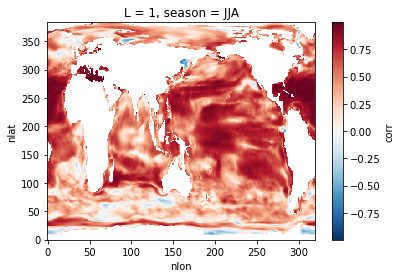

In [81]:
smyle05_corr.corr.isel(L=0).plot()

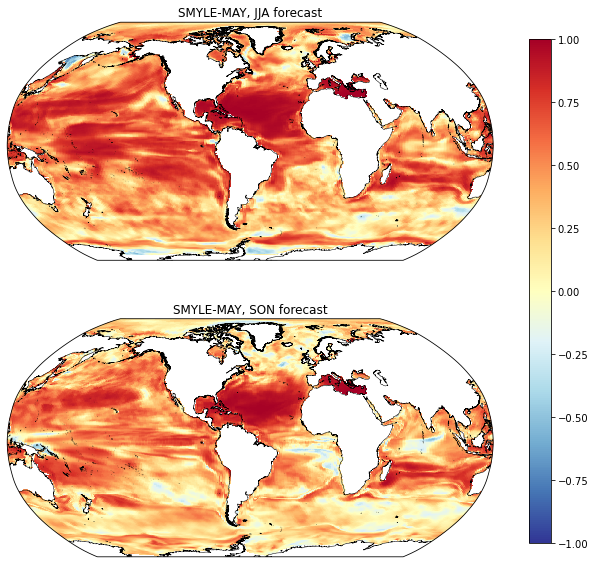

In [85]:
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(2,1,1, projection=ccrs.Robinson(central_longitude=305.0))

#### May initialization, JJA
ax.set_title('SMYLE-MAY, JJA forecast', fontsize=12)

lon,lat,field = maps.adjust_pop_grid(smyle05_corr.lon,smyle05_corr.lat,smyle05_corr.corr.isel(L=0))
pc = ax.pcolormesh(lon,lat,field,
                transform=ccrs.PlateCarree(),
                cmap='RdYlBu_r',vmin=-1,vmax=1)

ax.coastlines('10m',linewidth=0.5)

### May initialization, SON
ax = fig.add_subplot(2,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('SMYLE-MAY, SON forecast', fontsize=12)
lon,lat,field = maps.adjust_pop_grid(smyle05_corr.lon,smyle05_corr.lat,smyle05_corr.corr.isel(L=1))
pc = ax.pcolormesh(lon,lat,field,
                transform=ccrs.PlateCarree(),
                cmap='RdYlBu_r',vmin=-1,vmax=1)
ax.coastlines('10m',linewidth=0.5)


### color base
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.03, 0.7])
fig.colorbar(pc, cax=cbar_ax);

In [34]:
# %%time
# ci = 0.1
# cmin = -1.
# cmax = 1.
# hatchlevs = [0,0.1,100]
# fig = plt.figure(figsize=(18,15))
# nrows=7
# ncols=4

# proj = ccrs.PlateCarree(central_longitude=180)
# #proj = ccrs.Robinson(central_longitude=0)
# colstr = ['SMYLE-FEB','SMYLE-MAY','SMYLE-AUG','SMYLE-NOV']
# ltime = ['1','4','7','10','13','16','19']
# lstr = ''
# rstr = ''
# fsize=12
# fweight='bold'

# for i in range(nrows):
#     if i>0:
#         colstr=['','','','']
#     leadstr = ltime[i]+': '
#     ax1,cntr1 = maps.map_contourf_global_subplot(fig, smyle02_corr.corr.isel(L=i), smyle02_corr.lon, smyle02_corr.lat,
#                                        ci,cmin,cmax,colstr[0],lstr,rstr,nrows,ncols,i*ncols+1,proj,grid="pop")
#     lon, lat, dat = maps.adjust_pop_grid(smyle02_corr.lon, smyle02_corr.lat,smyle02_corr.pval.isel(L=i))
#     ax1.contourf(lon, lat, dat, colors='none',levels=hatchlevs, hatches=[None,'...', '...'], alpha=0., transform=ccrs.PlateCarree())
#     ldstr = ltime[i] + ': ' + str(smyle02_corr.isel(L=i).season.values)
#     ax1.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
    
#     ax2,cntr2 = maps.map_contourf_global_subplot(fig, smyle05_corr.corr.isel(L=i), smyle05_corr.lon, smyle05_corr.lat,
#                                        ci,cmin,cmax,colstr[1],lstr,rstr,nrows,ncols,i*ncols+2,proj,grid="pop")
#     lon, lat, dat = maps.adjust_pop_grid(smyle05_corr.lon, smyle05_corr.lat,smyle05_corr.pval.isel(L=i))
#     ax2.contourf(lon, lat, dat, colors='none',levels=hatchlevs, hatches=[None,'...', '...'], alpha=0., transform=ccrs.PlateCarree())
#     ldstr = ltime[i] + ': ' + str(smyle05_corr.isel(L=i).season.values)
#     ax2.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
    
#     ax3,cntr3 = maps.map_contourf_global_subplot(fig, smyle08_corr.corr.isel(L=i), smyle08_corr.lon, smyle08_corr.lat,
#                                        ci,cmin,cmax,colstr[2],lstr,rstr,nrows,ncols,i*ncols+3,proj,grid="pop")
#     lon, lat, dat = maps.adjust_pop_grid(smyle08_corr.lon, smyle08_corr.lat,smyle08_corr.pval.isel(L=i))
#     ax3.contourf(lon, lat, dat, colors='none',levels=hatchlevs,hatches=[None,'...', '...'], alpha=0., transform=ccrs.PlateCarree())
#     ldstr = ltime[i] + ': ' + str(smyle08_corr.isel(L=i).season.values)
#     ax3.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
    
#     ax4,cntr4 = maps.map_contourf_global_subplot(fig, smyle11_corr.corr.isel(L=i), smyle11_corr.lon, smyle11_corr.lat,
#                                        ci,cmin,cmax,colstr[3],lstr,rstr,nrows,ncols,i*ncols+4,proj,grid="pop")
#     lon, lat, dat = maps.adjust_pop_grid(smyle11_corr.lon, smyle11_corr.lat,smyle11_corr.pval.isel(L=i))
#     ax4.contourf(lon, lat, dat, colors='none',levels=hatchlevs, hatches=[None,'...', '...'], alpha=0., transform=ccrs.PlateCarree())
#     ldstr = ltime[i] + ': ' + str(smyle11_corr.isel(L=i).season.values)
#     ax4.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
    
#     #ax5,cntr5 = maps.map_contourf_global_subplot(fig, dple11_corr.corr.isel(L=i), dple11_corr.lon, dple11_corr.lat,
#     #                                   ci,cmin,cmax,colstr[4],lstr,rstr,nrows,ncols,i*5+5,proj)
#     #ax5.contourf(dple11_corr.lon, dple11_corr.lat,dple11_corr.pval.isel(L=i), colors='none',levels=hatchlevs,
#     #             hatches=[None,'...', '...'], alpha=0.)
#     #ldstr = ltime[i] + ': ' + str(dple11_corr.isel(L=i).season.values)
#     #ax5.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)


# fig.suptitle('NPP skill, linear-detrend',fontsize=20)
# fig.tight_layout()
# fig.subplots_adjust(bottom=0.08)
# cbar_ax = fig.add_axes([0.25, 0.04, 0.5, 0.02])
# fig.colorbar(cntr1, cax=cbar_ax, label='r', orientation='horizontal')
# plt.savefig('/glade/work/fredc/SMYLE/NPP_skill_linear-detrend.png')

In [36]:
%%time
smyle11_corr.to_netcdf('/glade/scratch/kristenk/SMYLE_paper/smyle11_NPP_skill_linear-detrend.nc')
smyle02_corr.to_netcdf('/glade/scratch/kristenk/SMYLE_paper/smyle02_NPP_skill_linear-detrend.nc')
smyle05_corr.to_netcdf('/glade/scratch/kristenk/SMYLE_paper/smyle05_NPP_skill_linear-detrend.nc')
smyle08_corr.to_netcdf('/glade/scratch/kristenk/SMYLE_paper/smyle08_NPP_skill_linear-detrend.nc')

CPU times: user 125 ms, sys: 22 ms, total: 147 ms
Wall time: 420 ms


### read in LME mask and do ACC on LMEs

In [39]:
file = '/glade/work/kristenk/fish-offline/fish-offline/notebooks/data/LME-mask-POP_gx1v6.nc'
ds_lme = xr.open_dataset(file)

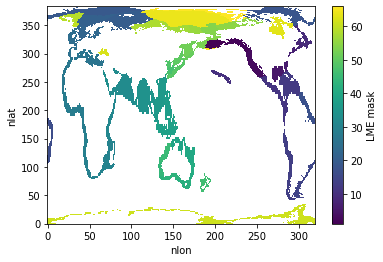

In [41]:
ds_lme.lme_mask.plot()

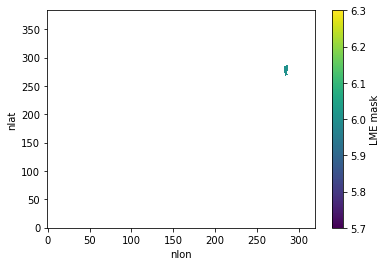

In [94]:
ds_lme.lme_mask.where(ds_lme.lme_mask ==6).plot()

In [125]:
import shapefile as shp

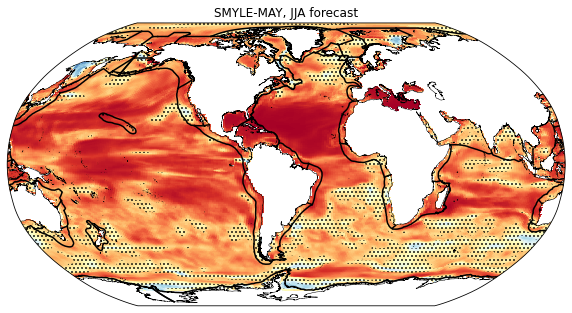

In [131]:
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))

sf = shp.Reader("/glade/work/kristenk/fish-offline/fish-offline/notebooks/data/LMEs66_Offshore")

hatchlevs = [0,0.1,100]

#### May initialization, JJA
ax.set_title('SMYLE-MAY, JJA forecast', fontsize=12)

lon,lat,field = maps.adjust_pop_grid(smyle05_corr.lon,smyle05_corr.lat,smyle05_corr.corr.isel(L=0))
pc = ax.pcolormesh(lon,lat,field,
                transform=ccrs.PlateCarree(),
                cmap='RdYlBu_r',vmin=-1,vmax=1)

for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    ax.plot(x,y,transform=ccrs.PlateCarree(),color='k')
    
lon, lat, dat = maps.adjust_pop_grid(smyle05_corr.lon, smyle05_corr.lat,smyle05_corr.pval.isel(L=0))
ax.contourf(lon, lat, dat, colors='none',levels=hatchlevs, 
             hatches=[None,'...', '...'], 
             alpha=0., transform=ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5);

### CA current

In [97]:
masked_fosi = fosi_seas.where(ds_lme.lme_mask == 3)
masked_forecast = smyle05_anom.photoC_TOT_zint_100m.where(ds_lme.lme_mask == 3)

weighted_mean_fosi = (masked_fosi * ds_lme.TAREA).sum(dim=('nlon','nlat')) / ds_lme.TAREA.sum(dim=('nlon','nlat'))
weighted_mean_forecast = (masked_forecast * ds_lme.TAREA).sum(dim=('nlon','nlat')) / ds_lme.TAREA.sum(dim=('nlon','nlat'))

smyle05_corr_lme3 = leadtime_corr_byseas(weighted_mean_forecast,smyle05.time,weighted_mean_fosi,detrend=True)

In [113]:
masked_fosi = fosi_seas.where(ds_lme.lme_mask == 3)
masked_forecast = smyle02_anom.photoC_TOT_zint_100m.where(ds_lme.lme_mask == 3)

weighted_mean_fosi = (masked_fosi * ds_lme.TAREA).sum(dim=('nlon','nlat')) / ds_lme.TAREA.sum(dim=('nlon','nlat'))
weighted_mean_forecast = (masked_forecast * ds_lme.TAREA).sum(dim=('nlon','nlat')) / ds_lme.TAREA.sum(dim=('nlon','nlat'))

smyle02_corr_lme3 = leadtime_corr_byseas(weighted_mean_forecast,smyle02.time,weighted_mean_fosi,detrend=True)

In [116]:
masked_fosi = fosi_seas.where(ds_lme.lme_mask == 3)
masked_forecast = smyle08_anom.photoC_TOT_zint_100m.where(ds_lme.lme_mask == 3)

weighted_mean_fosi = (masked_fosi * ds_lme.TAREA).sum(dim=('nlon','nlat')) / ds_lme.TAREA.sum(dim=('nlon','nlat'))
weighted_mean_forecast = (masked_forecast * ds_lme.TAREA).sum(dim=('nlon','nlat')) / ds_lme.TAREA.sum(dim=('nlon','nlat'))

smyle08_corr_lme3 = leadtime_corr_byseas(weighted_mean_forecast,smyle08.time,weighted_mean_fosi,detrend=True)

In [117]:
masked_fosi = fosi_seas.where(ds_lme.lme_mask == 3)
masked_forecast = smyle11_anom.photoC_TOT_zint_100m.where(ds_lme.lme_mask == 3)

weighted_mean_fosi = (masked_fosi * ds_lme.TAREA).sum(dim=('nlon','nlat')) / ds_lme.TAREA.sum(dim=('nlon','nlat'))
weighted_mean_forecast = (masked_forecast * ds_lme.TAREA).sum(dim=('nlon','nlat')) / ds_lme.TAREA.sum(dim=('nlon','nlat'))

smyle11_corr_lme3 = leadtime_corr_byseas(weighted_mean_forecast,smyle11.time,weighted_mean_fosi,detrend=True)

#### write out CA currrent ACC vals

In [132]:
%%time
smyle11_corr_lme3.to_netcdf('/glade/scratch/kristenk/SMYLE_paper/smyle11_NPP_skill_linear-detrend_lme3.nc')
smyle02_corr_lme3.to_netcdf('/glade/scratch/kristenk/SMYLE_paper/smyle02_NPP_skill_linear-detrend_lme3.nc')
smyle05_corr_lme3.to_netcdf('/glade/scratch/kristenk/SMYLE_paper/smyle05_NPP_skill_linear-detrend_lme3.nc')
smyle08_corr_lme3.to_netcdf('/glade/scratch/kristenk/SMYLE_paper/smyle08_NPP_skill_linear-detrend_lme3.nc')

CPU times: user 14.4 ms, sys: 927 µs, total: 15.4 ms
Wall time: 23.4 ms


In [98]:
smyle05_corr_lme3.corr.values

array([0.72406749, 0.75095654, 0.3351931 , 0.54985711, 0.39162214,
       0.41183889, 0.06487688,        nan])

### SE US continental shelf

In [99]:
lme_num = 6

masked_fosi = fosi_seas.where(ds_lme.lme_mask == lme_num)
masked_forecast = smyle05_anom.photoC_TOT_zint_100m.where(ds_lme.lme_mask == lme_num)

weighted_mean_fosi = (masked_fosi * ds_lme.TAREA).sum(dim=('nlon','nlat')) / ds_lme.TAREA.sum(dim=('nlon','nlat'))
weighted_mean_forecast = (masked_forecast * ds_lme.TAREA).sum(dim=('nlon','nlat')) / ds_lme.TAREA.sum(dim=('nlon','nlat'))

smyle05_corr_lme6 = leadtime_corr_byseas(weighted_mean_forecast,smyle05.time,weighted_mean_fosi,detrend=True)

In [115]:
lme_num = 6

masked_fosi = fosi_seas.where(ds_lme.lme_mask == lme_num)
masked_forecast = smyle02_anom.photoC_TOT_zint_100m.where(ds_lme.lme_mask == lme_num)

weighted_mean_fosi = (masked_fosi * ds_lme.TAREA).sum(dim=('nlon','nlat')) / ds_lme.TAREA.sum(dim=('nlon','nlat'))
weighted_mean_forecast = (masked_forecast * ds_lme.TAREA).sum(dim=('nlon','nlat')) / ds_lme.TAREA.sum(dim=('nlon','nlat'))

smyle02_corr_lme6 = leadtime_corr_byseas(weighted_mean_forecast,smyle02.time,weighted_mean_fosi,detrend=True)

In [118]:
lme_num = 6

masked_fosi = fosi_seas.where(ds_lme.lme_mask == lme_num)
masked_forecast = smyle08_anom.photoC_TOT_zint_100m.where(ds_lme.lme_mask == lme_num)

weighted_mean_fosi = (masked_fosi * ds_lme.TAREA).sum(dim=('nlon','nlat')) / ds_lme.TAREA.sum(dim=('nlon','nlat'))
weighted_mean_forecast = (masked_forecast * ds_lme.TAREA).sum(dim=('nlon','nlat')) / ds_lme.TAREA.sum(dim=('nlon','nlat'))

smyle08_corr_lme6 = leadtime_corr_byseas(weighted_mean_forecast,smyle08.time,weighted_mean_fosi,detrend=True)

In [119]:
lme_num = 6

masked_fosi = fosi_seas.where(ds_lme.lme_mask == lme_num)
masked_forecast = smyle11_anom.photoC_TOT_zint_100m.where(ds_lme.lme_mask == lme_num)

weighted_mean_fosi = (masked_fosi * ds_lme.TAREA).sum(dim=('nlon','nlat')) / ds_lme.TAREA.sum(dim=('nlon','nlat'))
weighted_mean_forecast = (masked_forecast * ds_lme.TAREA).sum(dim=('nlon','nlat')) / ds_lme.TAREA.sum(dim=('nlon','nlat'))

smyle11_corr_lme6 = leadtime_corr_byseas(weighted_mean_forecast,smyle11.time,weighted_mean_fosi,detrend=True)

#### write out SE US continental shelf ACC vals

In [133]:
%%time
smyle11_corr_lme6.to_netcdf('/glade/scratch/kristenk/SMYLE_paper/smyle11_NPP_skill_linear-detrend_lme6.nc')
smyle02_corr_lme6.to_netcdf('/glade/scratch/kristenk/SMYLE_paper/smyle02_NPP_skill_linear-detrend_lme6.nc')
smyle05_corr_lme6.to_netcdf('/glade/scratch/kristenk/SMYLE_paper/smyle05_NPP_skill_linear-detrend_lme6.nc')
smyle08_corr_lme6.to_netcdf('/glade/scratch/kristenk/SMYLE_paper/smyle08_NPP_skill_linear-detrend_lme6.nc')

CPU times: user 14.4 ms, sys: 0 ns, total: 14.4 ms
Wall time: 22.8 ms


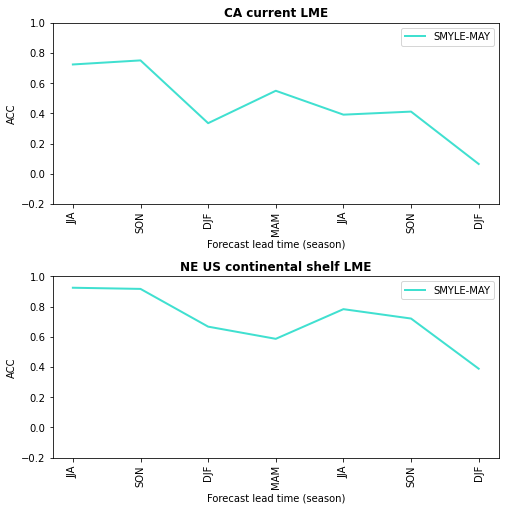

In [134]:
fig = plt.figure(figsize=(8,8))

xvals = np.arange(0,7,1)
xlabs = ['JJA','SON','DJF','MAM','JJA','SON','DJF']

ax = fig.add_subplot(2,1,1)
ax.set_title('CA current LME',fontsize=12,fontweight='bold',x=0.5)
ax.set_ylabel('ACC')
ax.set_xlabel('Forecast lead time (season)')
ax.set_ylim(-0.2,1)
ax.plot(xvals,smyle05_corr_lme3.corr.isel(L=slice(0,7)), 
         color='turquoise', label='SMYLE-MAY', lw=2)

plt.xticks(xvals, xlabs, rotation='vertical')
ax.legend();

ax = fig.add_subplot(2,1,2)
ax.set_title('NE US continental shelf LME',fontsize=12,fontweight='bold',x=0.5)
ax.set_ylabel('ACC')
ax.set_xlabel('Forecast lead time (season)')
ax.set_ylim(-0.2,1)
ax.plot(xvals,smyle05_corr_lme6.corr.isel(L=slice(0,7)), 
         color='turquoise', label='SMYLE-MAY', lw=2)

plt.xticks(xvals, xlabs, rotation='vertical')
ax.legend();
fig.subplots_adjust(hspace=0.4)

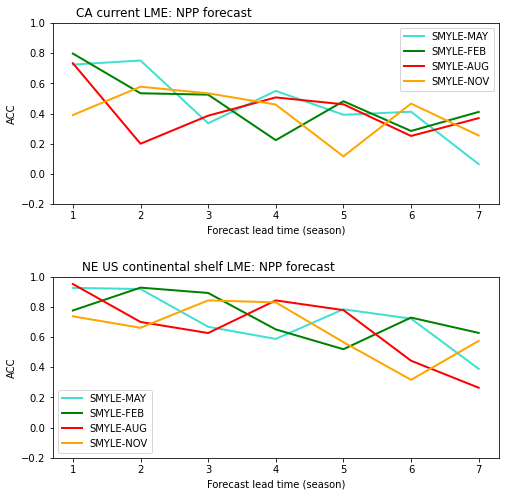

In [135]:
fig = plt.figure(figsize=(8,8))

xvals = np.arange(1,8,1)
#xlabs = ['JJA','SON','DJF','MAM','JJA','SON','DJF']

ax = fig.add_subplot(2,1,1)
ax.set_title('CA current LME: NPP forecast',fontsize=12,x=0.25)
ax.set_ylabel('ACC')
ax.set_xlabel('Forecast lead time (season)')
ax.set_ylim(-0.2,1)
ax.plot(xvals,smyle05_corr_lme3.corr.isel(L=slice(0,7)), 
         color='turquoise', label='SMYLE-MAY', lw=2)
ax.plot(xvals,smyle02_corr_lme3.corr.isel(L=slice(0,7)), 
         color='green', label='SMYLE-FEB', lw=2)
ax.plot(xvals,smyle08_corr_lme3.corr.isel(L=slice(0,7)), 
         color='red', label='SMYLE-AUG', lw=2)
ax.plot(xvals,smyle11_corr_lme3.corr.isel(L=slice(0,7)), 
         color='orange', label='SMYLE-NOV', lw=2)
#plt.xticks(xvals, xlabs, rotation='vertical')
ax.legend();

ax = fig.add_subplot(2,1,2)
ax.set_title('NE US continental shelf LME: NPP forecast',fontsize=12,x=0.35)
ax.set_ylabel('ACC')
ax.set_xlabel('Forecast lead time (season)')
ax.set_ylim(-0.2,1)
ax.plot(xvals,smyle05_corr_lme6.corr.isel(L=slice(0,7)), 
         color='turquoise', label='SMYLE-MAY', lw=2)
ax.plot(xvals,smyle02_corr_lme6.corr.isel(L=slice(0,7)), 
         color='green', label='SMYLE-FEB', lw=2)
ax.plot(xvals,smyle08_corr_lme6.corr.isel(L=slice(0,7)), 
         color='red', label='SMYLE-AUG', lw=2)
ax.plot(xvals,smyle11_corr_lme6.corr.isel(L=slice(0,7)), 
         color='orange', label='SMYLE-NOV', lw=2)
#plt.xticks(xvals, xlabs, rotation='vertical')
ax.legend();
fig.subplots_adjust(hspace=0.4)